In [94]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from pinballrt.sources import Star
from pinballrt.grids import UniformCartesianGrid, UniformSphericalGrid
from pinballrt.model import Model
from pinballrt.densities.flared_disk import FlaredDisk
from matplotlib.colors import LogNorm
import xarray as xr

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
star = Star()
star.set_blackbody_spectrum()
disk = FlaredDisk()

In [96]:
model = Model(grid=UniformCartesianGrid, grid_kwargs={"ncells": (24, 24, 24), "dx": 4*u.au})

In [97]:
model.add_component(disk, 'yso.dst')
model.add_star(star)

/Users/bdrechsler/miniconda3/envs/pinballrt/lib/python3.11/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/bdrechsler/miniconda3/envs/pinballrt/lib/python3.11/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(24, 24, 24)


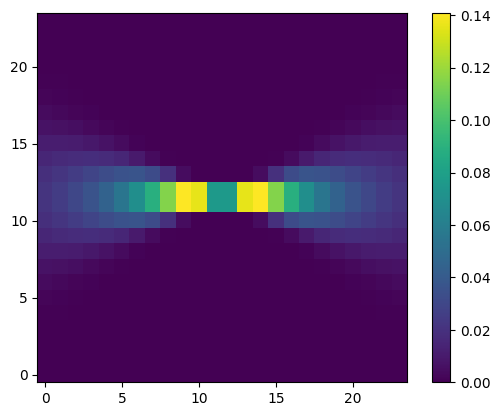

In [98]:
density = model.grid.grid.density.numpy()
print(density.shape)

plt.imshow(np.transpose(density[10,:,:]), origin='lower')
plt.colorbar()
plt.show()

In [99]:
# model.thermal_mc(nphotons=1000000, device="cuda")
model.thermal_mc(nphotons=1000000)

Iteration 0


100%|██████████| 1000000/1000000 [00:02<00:00, 350094.85it/s]
/Users/bdrechsler/Code/pinball-rt/pinballrt/grids.py:379: RuntimeWarning: invalid value encountered in divide
  temperature = ((total_energy*u.L_sun).cgs.value / (4*const.sigma_sb.cgs.value*\


0
Iteration 1


100%|██████████| 1000000/1000000 [00:02<00:00, 349423.21it/s]


1
Iteration 2


100%|██████████| 1000000/1000000 [00:02<00:00, 337276.65it/s]


2 1.0663604 1.5520058
Iteration 3


100%|██████████| 1000000/1000000 [00:02<00:00, 336337.84it/s]

3 1.0551891 1.010587


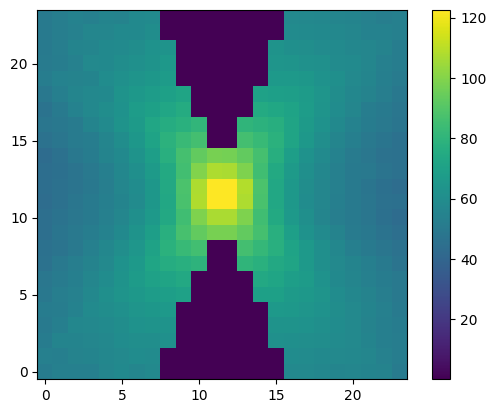

In [100]:
temp = model.grid.grid.temperature.numpy()

plt.imshow(np.transpose(temp[10,:,:]), origin='lower')
plt.colorbar()
plt.show()

In [9]:
# img = model.make_image(npix=100, distance=1*u.pc, pixel_size=2*u.arcsec, lam=np.array([4, 1000])*u.um, incl=85*u.deg, pa=0*u.deg, device='cuda')

In [101]:
img = model.make_image(npix=50, distance=1*u.pc, pixel_size=2*u.arcsec, lam=np.array([1000])*u.um, incl=80*u.deg, pa=0*u.deg, device='cpu')


100%|██████████| 100000/100000 [00:00<00:00, 455174.33it/s]

Time: 2.197983980178833
2500


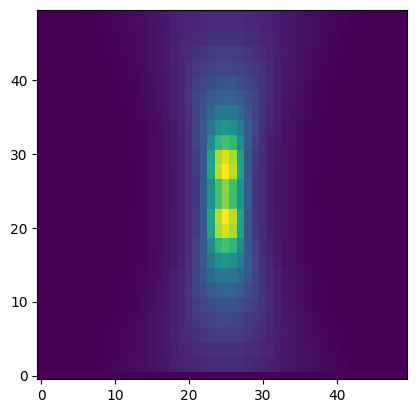

In [102]:
plt.imshow(img.intensity[:,:,0], origin='lower')
plt.show()

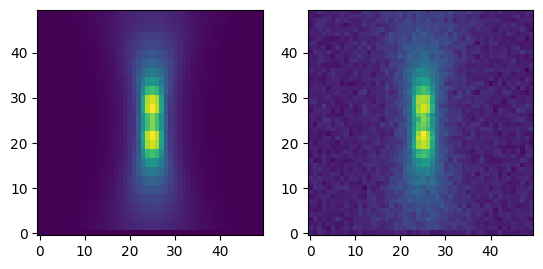

In [103]:
img_data = img.intensity

noise = np.zeros((img.sizes['x'], img.sizes['y'], img.sizes['lam']))
noise[:,:,0] += np.random.normal(loc=0, scale=img_data.std()/5, size=(50,50))

noisy_data = img_data.to_numpy() + noise


fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_data, origin='lower')
ax[1].imshow(noisy_data, origin='lower')
plt.show()

In [104]:
fake_data = xr.DataArray(noisy_data, dims=("x", "y", "lam"))
nx, ny, nlam = noisy_data.shape
ds = xr.Dataset(
    data_vars = dict(intensity=(["x", "y", "lam"], noisy_data * u.arcsec**2*u.Jy/u.sr),
                     err=(["x", "y", "lam"], noise*u.arcsec**2*u.Jy/u.sr)),
    coords = dict(x=("x", img.x.to_numpy()),
                  y=("y", img.y.to_numpy()),
                  lam=("lam", img.lam.to_numpy()),
                  nu=("nu", img.nu.to_numpy()))
)
ds

<xarray.Dataset> Size: 41kB
Dimensions:    (x: 50, y: 50, lam: 1, nu: 1)
Coordinates:
  * x          (x) float64 400B -50.0 -48.0 -46.0 -44.0 ... 42.0 44.0 46.0 48.0
  * y          (y) float64 400B -50.0 -48.0 -46.0 -44.0 ... 42.0 44.0 46.0 48.0
  * lam        (lam) float64 8B 1e+03
  * nu         (nu) float64 8B 299.8
Data variables:
    intensity  (x, y, lam) float64 20kB -1.441e+07 arcsec2 Jy / sr ... 4.001e...
    err        (x, y, lam) float64 20kB -1.441e+07 arcsec2 Jy / sr ... 3.868e...

In [105]:
model.log_l(ds)

<xarray.DataArray ()> Size: 8B
<Quantity -1250.>